In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 
from sklearn.model_selection import train_test_split
import torchvision.models as models

from Sources.callbacks import plot_confusion_matrix
from Sources.CoAtNet import CoAtNet
from torch.nn import functional as F
from Sources.callbacks import get_true_classes
from Sources.callbacks import get_predicted_classes
from Sources.callbacks import get_classes_probs
from Sources.callbacks import callback
from Sources.data_tools import ImageDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

labels_map = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

Using cuda device


In [3]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 3)
model = model.to(device)
model.load_state_dict(torch.load("../Logits/SavedNN/Saved_ResNet/" + str(50)))
model.eval()
None

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: 1
torch.Size([224, 224, 3])


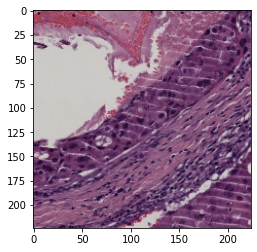

Label: 1


In [4]:
transform_for_maps = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageDataset('../Data/burnasyan_Br.csv', 'val_paths.txt', transform = transform_for_maps)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze().permute(1, 2, 0).int()
print(img.shape)
label = labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

## GradCAM

In [9]:
from Sources.pytorch_grad_cam_master.pytorch_grad_cam import GradCAM
from Sources.pytorch_grad_cam_master.pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]

input_tensor = features.to(device)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

target_category = 1

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [10]:
img = features.cpu().detach() / 255
img = img.squeeze().permute(1, 2, 0).numpy()

In [11]:
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

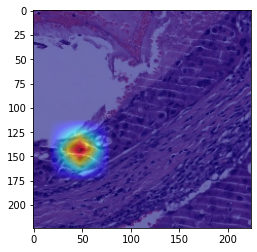

In [12]:
plt.imshow(visualization)
plt.show()

In [17]:
np.unique(grayscale_cam)

array([0.        , 0.00130161, 0.00133313, ..., 0.99745566, 0.99874234,
       0.9999999 ], dtype=float32)